Based on:
*   https://arxiv.org/pdf/1803.05400.pdf
*   https://github.com/PartheshSoni/Image-colorization-using-GANs/blob/master/ImageColourization.ipynb


In [ ]:

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

from google.colab import files
import smtplib

from sklearn.utils import shuffle
from google.colab import drive

import torch
import torch.nn as nn


In [ ]:
drive.mount('/content/gdrive',force_remount=True)
data_path = '/content/gdrive/My Drive/DeepLearning_2020/FinalProject/Data/'
results_path = '/content/gdrive/My Drive/DeepLearning_2020/FinalProject/Results/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


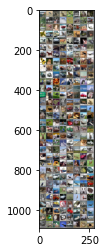

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_gray(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg)
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))  

# Class encoder decoder

In [ ]:
import torch
import torch.nn as nn

# Encoder definition with 3 COnv-BN-ReLU blocks and fully-connected layer
class Encoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Encoder, self).__init__()

    self.C1 = nn.Conv2d(3,64,kernel_size=1,stride = 1,padding = 0)
    self.C2 = nn.Conv2d(64,128,kernel_size=2,stride = 2,padding = 0)
    self.C3 = nn.Conv2d(128,256,kernel_size=2,stride = 2,padding = 0)

    self.batchnorm1 = nn.BatchNorm2d(64)
    self.batchnorm2 = nn.BatchNorm2d(128)
    self.batchnorm3 = nn.BatchNorm2d(256)

    self.LReLU = nn.LeakyReLU(0.2)

    self.fc1 = nn.Linear(256*8*8,1)
  
  def forward(self,x):
    C1 = self.C1(x)
    C1 = self.batchnorm1(C1)
    C1 = self.LReLU(C1)

    C2 = self.C2(C1)
    C2 = self.batchnorm2(C2)
    C2 = self.LReLU(C2)

    C3 = self.C3(C2)
    C3 = self.batchnorm3(C3)
    C3 = self.LReLU(C3)

    D = C3.view(C3.shape[0],-1)
    D = self.fc1(D)

    return torch.sigmoid(D)
    
# Decoder definition with a fully-connected layer and 3 BN-ReLU-COnv blocks and 
class Decoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Decoder, self).__init__()
    self.base_channels = base_channels

    self.C1 = nn.Conv2d(1,64,kernel_size=1,stride = 1,padding = 0)
    self.C2 = nn.Conv2d(64,128,kernel_size=2,stride = 2,padding = 0)
    self.C3 = nn.Conv2d(128,256,kernel_size=2,stride = 2,padding = 0)
    
    self.c_batchnorm1 = nn.BatchNorm2d(64)
    self.c_batchnorm2 = nn.BatchNorm2d(128)
    self.c_batchnorm3 = nn.BatchNorm2d(256)

    self.DC1 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2,padding = 0)
    self.DC2 = nn.ConvTranspose2d(256,64,kernel_size=2,stride=2,padding = 0)

    self.batchnorm1 = nn.BatchNorm2d(128)
    self.batchnorm2 = nn.BatchNorm2d(64)

    self.merging = nn.Conv2d(128,3,kernel_size=1,stride = 1,padding = 0)

    self.dropout = nn.Dropout2d(0.5)
    self.LReLU = nn.LeakyReLU(0.2)
  
  def forward(self,x):
    C1 = self.C1(x)
    C1 = self.LReLU(self.c_batchnorm1(C1))

    C2 = self.C2(C1)
    C2 = self.LReLU(self.c_batchnorm2(C2))

    C3 = self.C3(C2)
    C3 = self.LReLU(self.c_batchnorm3(C3))

    #####
    DC1 = self.DC1(C3)
    DC1 = self.LReLU(self.batchnorm1(DC1))
    DC1 = torch.cat((DC1,C2),dim=1)
    DC1 = self.dropout(DC1)
    
    DC2 = self.DC2(DC1)
    DC2 = self.LReLU(self.batchnorm2(DC2))
    DC2 = torch.cat((DC2,C1),dim=1)
    
    CC4 = self.merging(DC2)
    # print(CC4.size())

    return torch.tanh(CC4)

#Discriminator and Generator


In [ ]:
# Discriminator similar to VAE encoder
class Discriminator(nn.Module):
  def __init__(self, base_channels=16):
    super(Discriminator, self).__init__()
    # last fully connected layer acts as a a binary classifier
    self.classifier = Encoder(3,base_channels)

  # Forward pass obtaining the discriminator probability
  def forward(self,x):
    out = self.classifier(x)
    # use sigmoid to get the real/fake image probability
    return torch.sigmoid(out)

# Generator is defined as VAE decoder
class Generator(nn.Module):
  def __init__(self,in_features,base_channels=16):
    super(Generator, self).__init__()
    self.base_channels = base_channels
    self.in_features = in_features
    self.decoder = Decoder(in_features,base_channels)

  # Generate an image from vector z
  def forward(self,z):
    return torch.sigmoid(self.decoder(z))

  # Sample a set of images from random vectors z
  def sample(self,grey_images):
    return self.decoder(grey_images)

In [ ]:
def toGrey(images):
  s = list(images.size())
  r = torch.zeros(s[0],1,s[2],s[3])
  r[:,0,:,:] = images[:,0,:,:]*0.2989 + images[:,1,:,:]*0.5870 +images[:,2,:,:]*0.1140
  return r

In [ ]:
# GAN Train function. We have a generator and discriminator models and their respective optimizers.
def train_GAN(gen, disc,  train_loader, optimizer_gen, optim_disc, adverasarial_weight = 1.0,
              num_epochs=10, model_name='gan_color.ckpt', device='cpu'):
    gen = gen.to(device)
    gen.train() # Set the generator in train mode
    disc = disc.to(device)
    disc.train() # Set the discriminator in train mode

    total_step = len(train_loader)
    losses_list = []
    mse_loss = nn.MSELoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        error_loss_avg = 0

        nBatches = 0
        update_generator = True

        for i, (real_images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            real_images = real_images.to(device)
            n_images = real_images.shape[0]

            # Forward pass
            # Use greyScale images as 
            # print(type(real_images))
            grey_images = toGrey(real_images).to(device)

            if i == 0 :
              gen.eval()
              fake_images = gen.sample(grey_images)
              imshow_gray(real_images[0,0].cpu())
              imshow(fake_images[0].cpu())
              imshow(real_images[0].cpu())
              gen.train()
              print(fake_images.shape,real_images.shape)

            fake_images = gen.sample(grey_images)

            # fake_images = np.dot(real_images[...,:3], [0.2989, 0.5870, 0.1140])
            # fake_images = toGrey(real_images)
            
            # Use the discriminator to obtain the probabilties for real and generate imee
            prob_real = disc(real_images)
            prob_fake = disc(fake_images)
            
            # Generator loss
            #gen_loss = -torch.log(prob_fake).mean()
            error_loss = mse_loss(fake_images,real_images)
            gen_loss = -torch.log(prob_fake).mean()*adverasarial_weight
            # Discriminator loss
            disc_loss = -0.5*(torch.log(prob_real) + torch.log(1-prob_fake)).mean()

            
            # We are going to update the discriminator and generator parameters alternatively at each iteration

            if(update_generator):
              # Optimize generator
              # Backward and optimize
              optimizer_gen.zero_grad()
              (gen_loss+error_loss).backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
              optimizer_gen.step()
              update_generator = False
            else:           
              # Optimize discriminator
              # Backward and optimize
              optimizer_disc.zero_grad()
              disc_loss.backward()
              optimizer_disc.step()
              update_generator = True
                

            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()
            error_loss_avg = error_loss.cpu().item()
            nBatches+=1
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f},, Error Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches, error_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f},, Error Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches, error_loss_avg / nBatches))
        # Save model
        losses_list.append(disc_loss_avg / nBatches)
        torch.save(gan_gen.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

In [ ]:
# Define Geneartor and Discriminator networks
gan_gen = Generator(32)
gan_disc = Discriminator()

print(gan_gen)
print(gan_disc)
#Initialize indepdent optimizer for both networks
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = 0.0001, weight_decay=1e-5)
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = 0.0001, weight_decay=1e-5)

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_list = train_GAN(gan_gen,gan_disc, train_loader, optimizer_gen, optimizer_disc, adverasarial_weight = 0.5,num_epochs=100, model_name='gan_color_do05_aw05.ckpt', device=device)

TEST


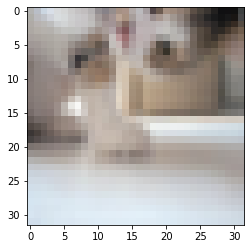

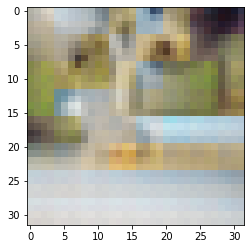

In [ ]:
# Load generator
gan_gen = Generator(32)
# Change file name to test different model. Tables with configurations used in README
gan_gen.load_state_dict(torch.load(results_path+'/gan_color2.ckpt'))
gan_gen.eval() # Put in eval model
gan_gen = gan_gen.to(device)

# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
grey_images = toGrey(images)
x_gen = gan_gen.sample(grey_images.to(device))

imshow(images[0])
imshow(x_gen[0].cpu())

